# SCimilarity search using centroids and gene signatures

The goal of this tutorial is to demonstrate a more flexible method for cell search, using centroids. Much of the early steps will be identical to *cell_search_tutorial_1.ipynb* and thus the explanations for those steps will be reduced for the sake of brevity. We will again use the [Adams et al. 2020](https://www.science.org/doi/10.1126/sciadv.aba1983?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) healthy and IPF lung scRNA-seq data.

An important thing to note is that the cells inputed into the query are what determine the query results. The average of a scattered collection of cells will not bring meaningful results. There are some built-in QC stats with which you can evaluate the centroid quality and we will demonstrate them in this tutorial.

#### There will be two analyses shown for querying cells:
 1. Using a fibroblast signature, find cells of interest and perform cell search on their centroid.
 
 2. Using a non-specific signature, demonstrate how QC stats can indicate a poor centroid.

In [1]:
# Environment settings
import scanpy as sc
from matplotlib import pyplot as plt

sc.set_figure_params(dpi=100)
plt.rcParams['figure.figsize'] = [6, 4] 
plt.rcParams['figure.autolayout'] = True

import warnings
warnings.filterwarnings('ignore')

/home/kuot/miniconda3/envs/gpy/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## 1. Prepare for SCimilarity: Import and normalize data

In [2]:
from scimilarity.utils import lognorm_counts, align_dataset
from scimilarity import CellQuery

In [3]:
## TODO
## RESTRUCTURE THE MODEL PATHS FOR DOWNLOAD FILES

# If the models haven't been downloaded please uncomment and run the two command below
#!curl -L -o /models/query_model_v1.tar.gz https://zenodo.org/record/8240464/files/query_model_v1.tar.gz?download=1
#!tar -xzvf /models/query_model_v1.tar.gz

In [4]:
# Instantiate the CellQuery object.
# Replace model_path with your local file path.
model_path = '/models/model_v1'
cq = CellQuery(model_path)

### Load scRNA-seq data

In [5]:
# To Download the demo data to the data/ directory uncomment and run the command below
#! curl -L -o "{download_dir}/GSE136831_subsample.h5ad" https://zenodo.org/record/8242083/files/GSE136831_subsample.h5ad?download=1

In [6]:
# Load the tutorial data.
# Replace data_path with your local file path.
data_path = '/data/GSE136831_subsample.h5ad'
adams = sc.read(data_path)

In [7]:
adams = align_dataset(adams, cq.gene_order)
adams = lognorm_counts(adams)

## 2. Compute embeddings
Using the already trained models, SCimilarity can embed your new dataset. 

In [8]:
adams.obsm['X_scimilarity'] = cq.get_embeddings(adams.X)

In [9]:
sc.pp.neighbors(adams, use_rep='X_scimilarity')
sc.tl.umap(adams)

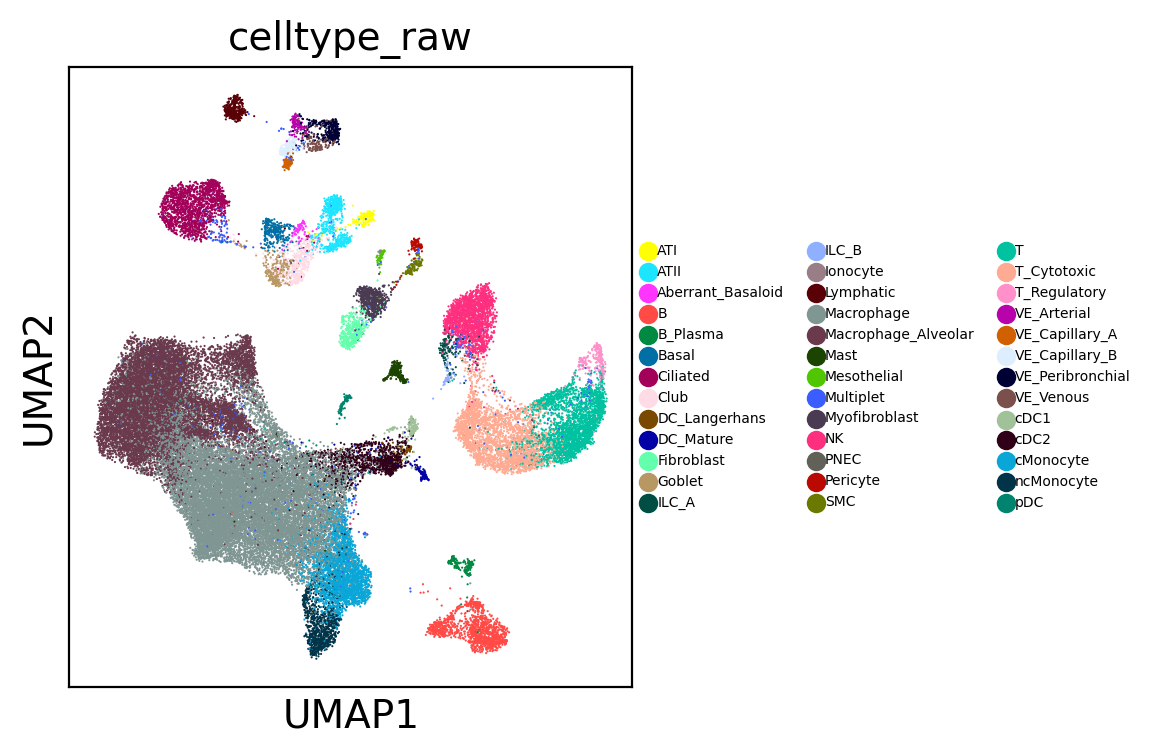

In [10]:
sc.pl.umap(adams, color='celltype_raw', legend_fontsize=5)

## 3. Identify query cell states

The more coherent and specific the cell population is the more interesting the results typically are. Cell subtypes/subclustering are usually more interesting.

In this example, we do not need celltype information to identify query cells, rather we will use a gene signature for fibroblasts and a non-specific signature to illustrate the QC metrics we use to evaluate centroid quality.

In [11]:
fibro_signature = ['ACTA2', 'CDH11', 'ELN',  'LOXL1', 'TNC', 'ASPN', 'COMP', 'CTHRC1', 'POSTN', 'COL1A1', 'COL3A1', 'COL8A1']
sc.tl.score_genes(adams, fibro_signature, score_name='fibro_score')

nonspecific_signature = ['SOX8', 'FABP4', 'IRS1', 'ADRA2A', 'PPARGC1A', 'SGK1', 'APOC3', 'NR4A1', 'FOSB', 'KLF7', 'GFRA2', 'RXRG', 'THRB']
sc.tl.score_genes(adams, nonspecific_signature, score_name='nonspecific_score')

In [12]:
sig_query_threshold = adams.obs['fibro_score'].quantile(.999)
cells_used_in_query = adams.obs['fibro_score'] >= sig_query_threshold
adams.obs['used_in_fibro_query'] = cells_used_in_query.astype(int)

sig_query_threshold = adams.obs['nonspecific_score'].quantile(.999)
cells_used_in_query = adams.obs['nonspecific_score'] >= sig_query_threshold
adams.obs['used_in_nonspecific_query'] = cells_used_in_query.astype(int)

As we are performing the search on a **centroid**, we very much want a tight collection of cells on which to calculate the centroid. Here we visualize the collection of cells to check coherence. These cells should ideally come from the same cluster and homogenous.

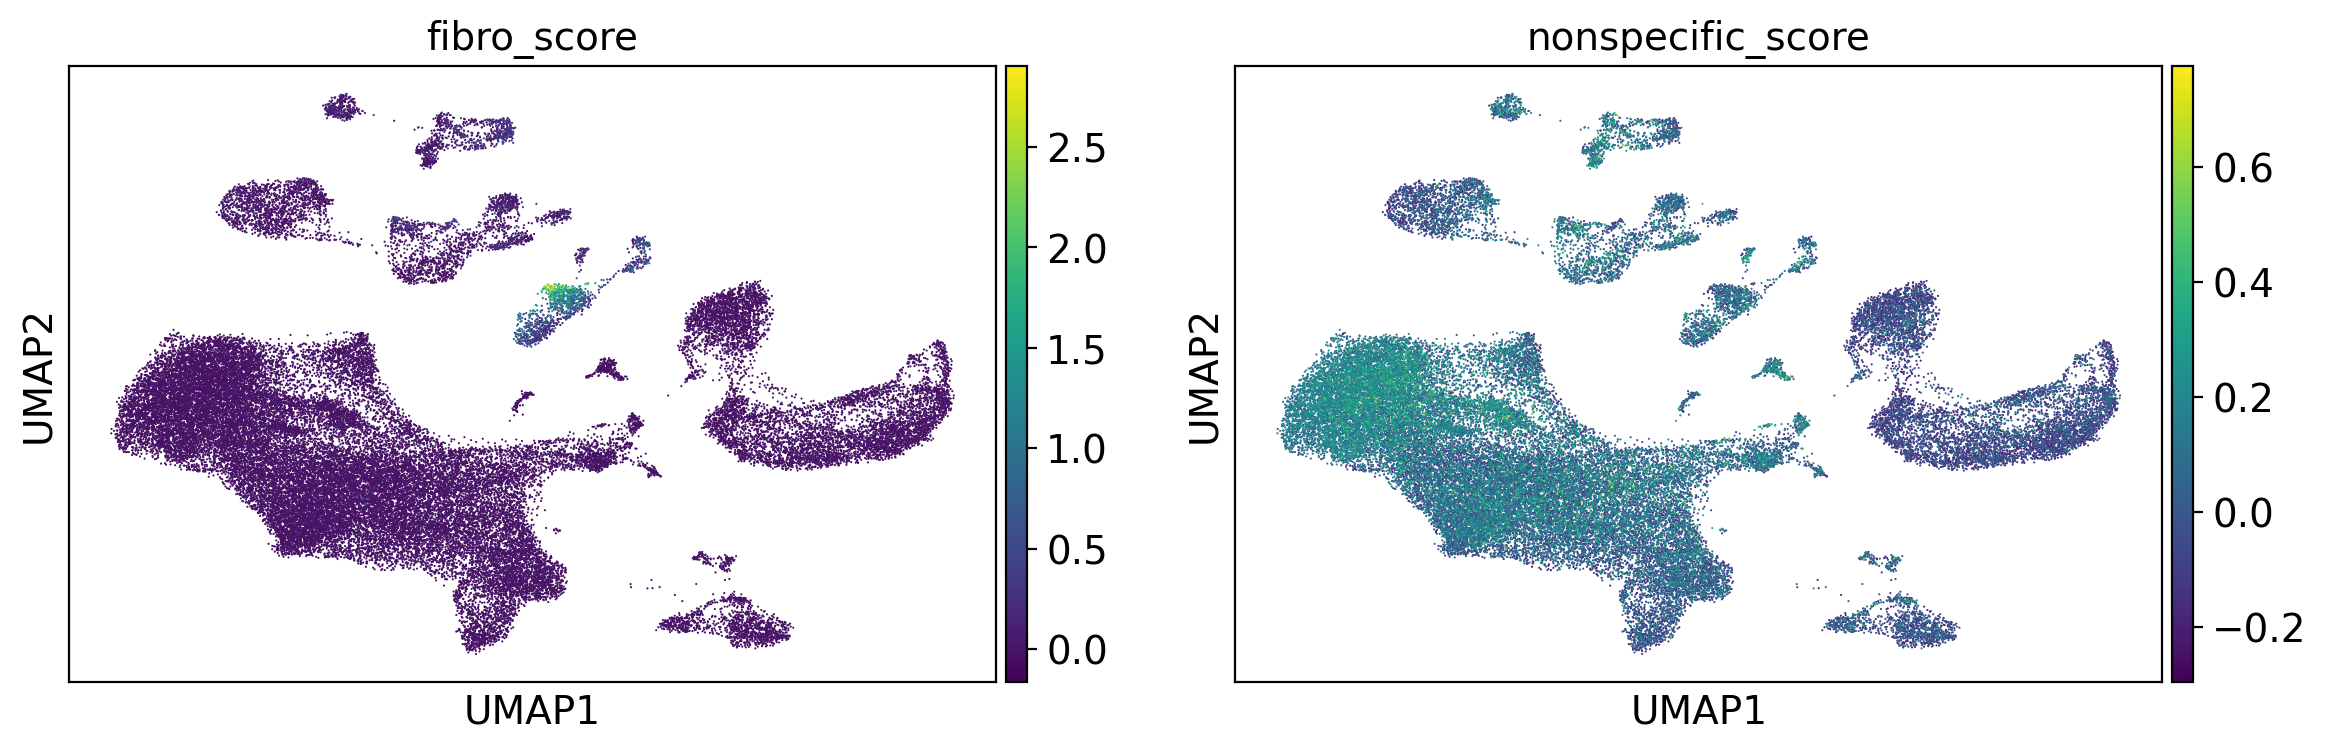

In [13]:
sc.pl.umap(adams, color=['fibro_score', 'nonspecific_score'])

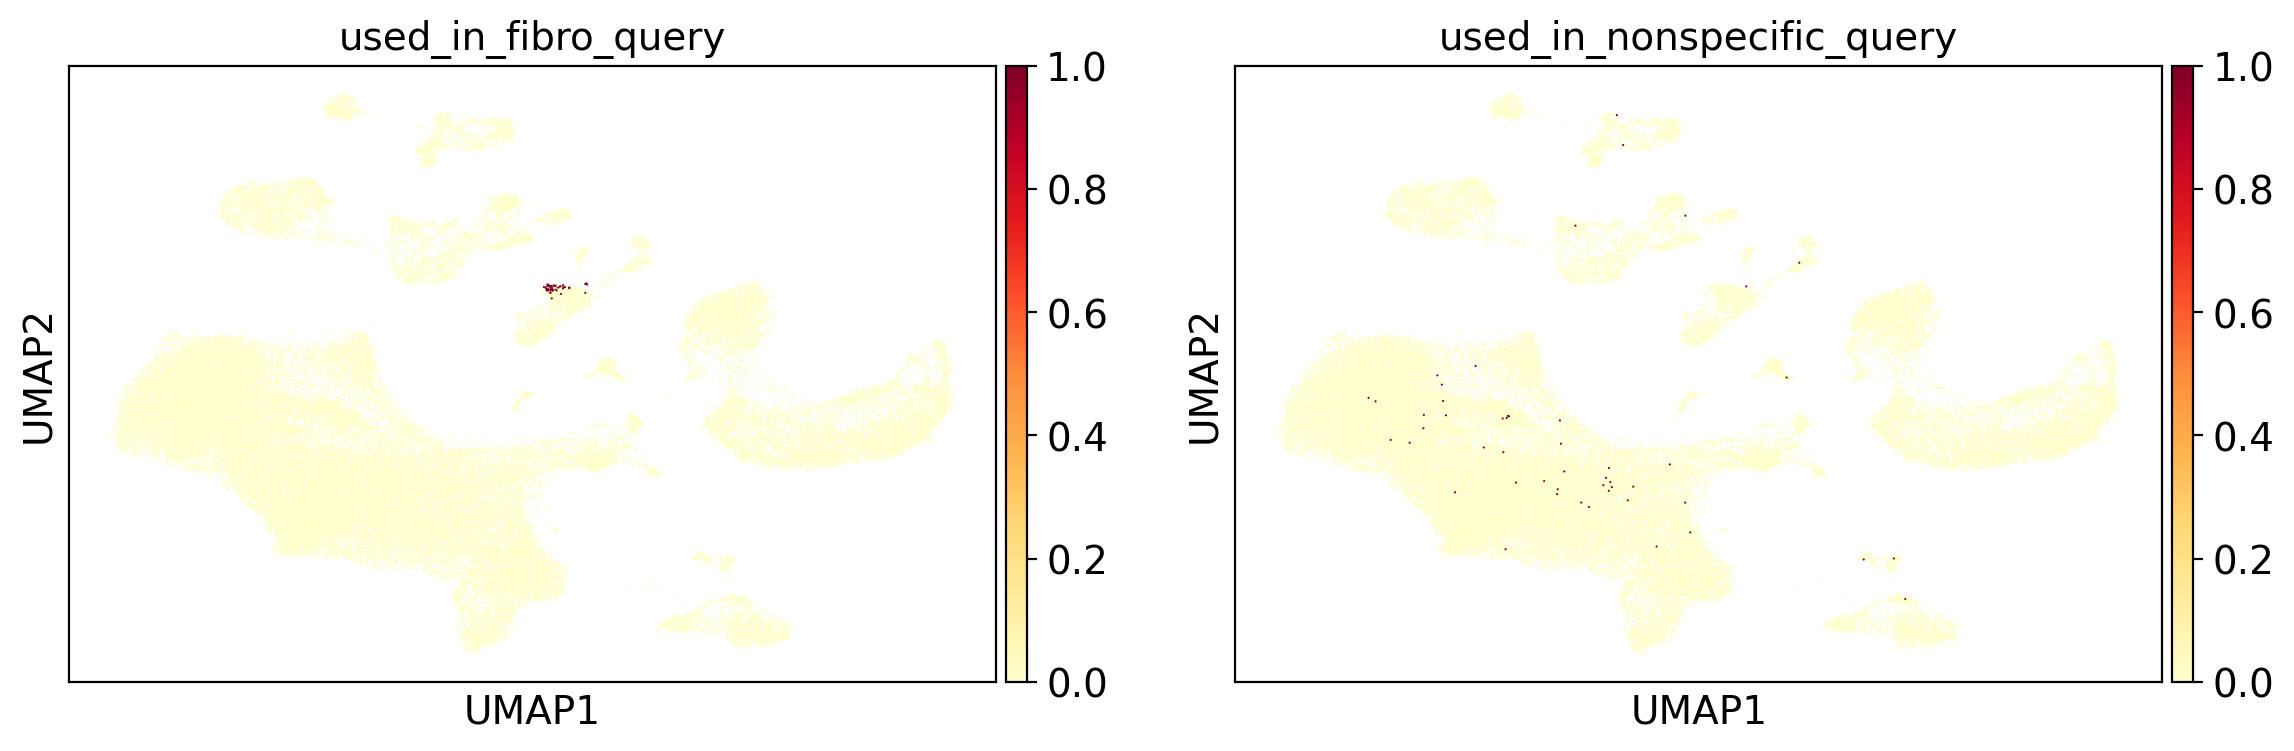

In [14]:
sc.pl.umap(adams, color=['used_in_fibro_query', 'used_in_nonspecific_query'], cmap="YlOrRd")

## 4. Perform cell search on centroid
The centroid search method provides a QC output with which you can evaluate the quality of the centroid and search results.

QC stats:
  - query_stability: The consistency of query results between the centroid and cells that comprise the centroid.

For more details, see the Section## in the paper.

In [15]:
centroid_embedding, nn_idxs, nn_dists, fibro_results_metadata, qc_stats = cq.search_centroid(adams, 'used_in_fibro_query')
print(qc_stats)

{'query_stability': 56.7}


In [16]:
centroid_embedding, nn_idxs, nn_dists, nonspecific_results_metadata, qc_stats = cq.search_centroid(adams, 'used_in_nonspecific_query')
print(qc_stats)

{'query_stability': 0.0}


In [17]:
def calculate_disease_proportions(metadata):
    study_proportions = metadata.disease.value_counts()
    return 100*study_proportions / study_proportions.sum()

def plot_proportions(df, title=None):
    ax = df.plot(kind='barh', 
            xlabel='percent of cells',
            title=title, 
            grid=False,
            figsize=(8,5))
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xticklabels([f'{int(tick)}%' for tick in ax.get_xticks()]);
    plt.tight_layout()

#### Exclude self-referencing results
Naturally, queries searching for similar cells will highlight cells from the same study. To get a clearer view of the results, we often exclude those self-referencing hits.

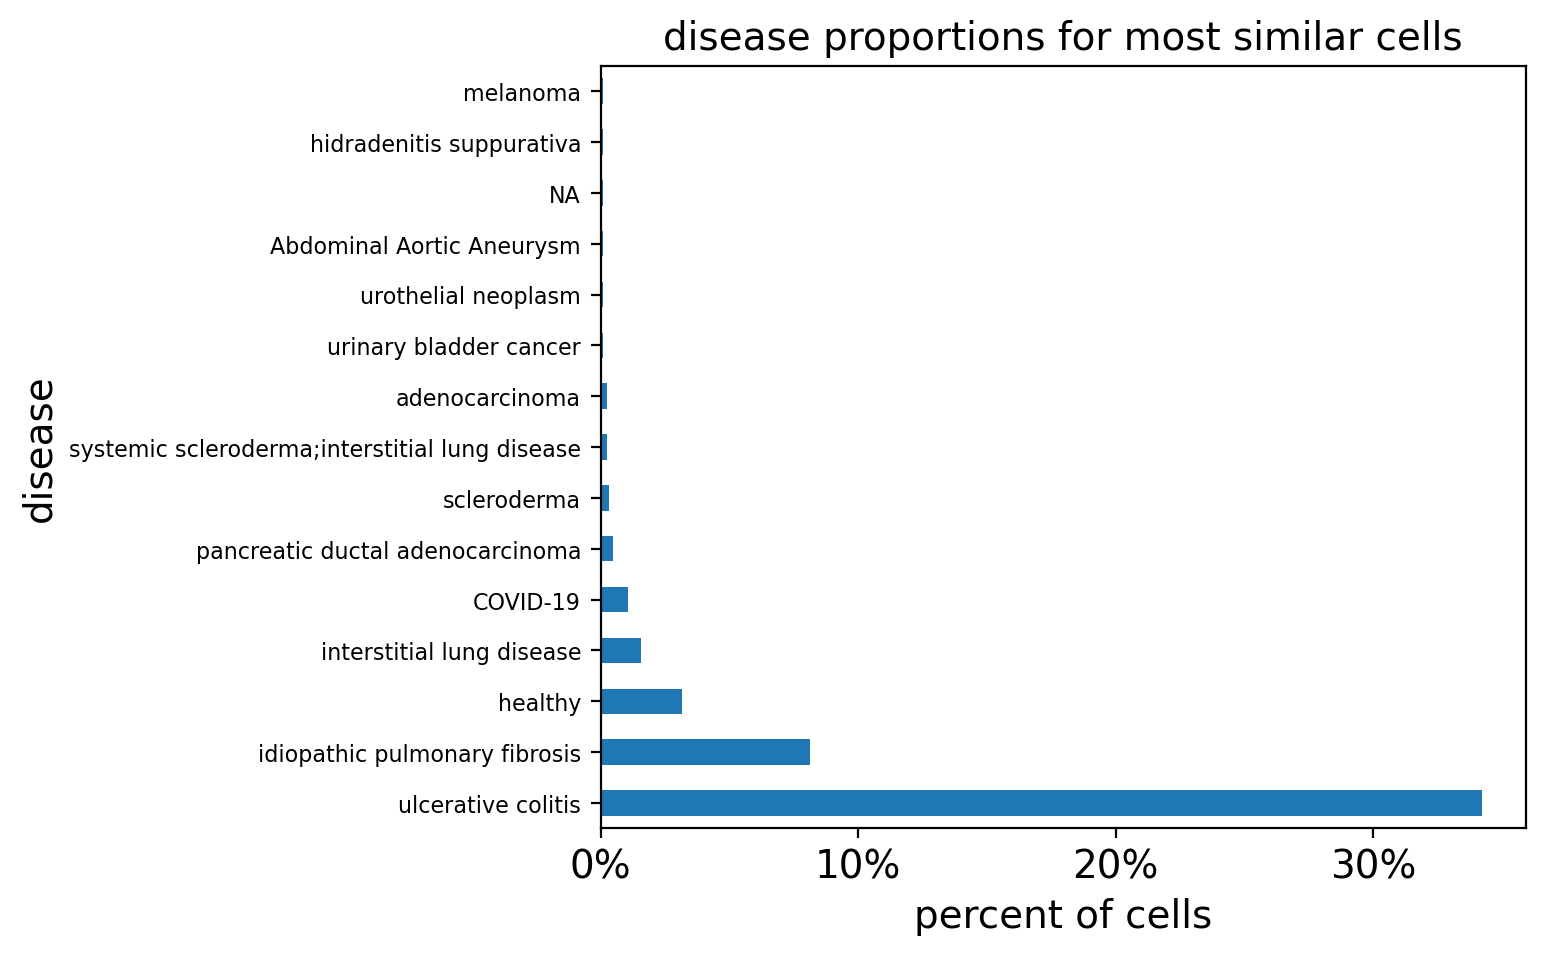

In [18]:
query_study = 'DS000011735'
filtered_result_metadata = fibro_results_metadata[fibro_results_metadata.study!=query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
plot_proportions(query_disease_frequencies, title='disease proportions for most similar cells')

In [19]:
query_study = 'DS000011735'
filtered_result_metadata = nonspecific_results_metadata[nonspecific_results_metadata.study!=query_study]
display(filtered_result_metadata)

,index,study,sample,prediction,fm_signature_score,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,prediction_nn_dist,...,ESC-derived,xenograft,tissue,cell_line_cleaned,disease,FACS_sort,sex_cleaned,author_label,embedding_idx,query_nn_dist


The results for the non-specific signature is empty after filtering out the query study because the centroid constructed is poor and could only match cells from the query study.

## Conclusion:
This notebook outlines the basics of how to take a dataset, construct a centroid from a gene signature, and perform a cell search across our precomputed indices for 22.7M cells and summarize the results. You can use this as a template to expore cell states in other datasets you are interested in. 


 - Keep in mind that the datasets that you analyze with SCimilarity should fit the following criteria:
   - Data generated from 10X Chromium machine (models are trained using this data only).
   - Human scRNA-seq data.
   - Normalized from counts with SCimilarity functions or using the same process. Different normalizations will have poor results.

## Next: Advanced cell search using cluster centroids
This notebook demonstrated SCimilarity cell search on centroids and described the QC metrics that can be used to evaluate the quality of a centroid. Another common method for grouping cells is from clusters or cell type labels. Our QC metrics can also be applied to cluster centroids to evaluate the quality of those centroids.

Check out the next tutorial to learn how to search cell cluster centroids using SCimilarity!